In [215]:
# import requests
# from bs4 import BeautifulSoup
# from datetime import date
# import re
# import time

# def parse_liquipedia_h2h(player: str, opponent: str,
#                          start_date: date, end_date: date) -> dict:
#     session = requests.Session()
    
#     session.headers = {
#         "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
#         "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
#         "Accept-Language": "en-US,en;q=0.9",
#         "Accept-Encoding": "gzip, deflate, br",
#         "Connection": "keep-alive",
#         "Upgrade-Insecure-Requests": "1",
#         "Sec-Fetch-Dest": "document",
#         "Sec-Fetch-Mode": "navigate",
#         "Sec-Fetch-Site": "none",
#         "Sec-Fetch-User": "?1",
#         "Cache-Control": "max-age=0",
#         "sec-ch-ua": '"Not_A Brand";v="8", "Chromium";v="120", "Google Chrome";v="120"',
#         "sec-ch-ua-mobile": "?0",
#         "sec-ch-ua-platform": '"Windows"',
#     }
    
#     try:
#         main_page = session.get(
#             "https://liquipedia.net/starcraft2/Main_Page",
#             timeout=10
#         )
#         time.sleep(2)
#     except:
#         pass
#     # end try
    
#     params = {
#         'title': 'Special:RunQuery/Match_history',
#         'Head_to_head_query[player]': player,
#         'Head_to_head_query[opponent]': opponent,
#         'Head_to_head_query[game]': 'Legacy of the Void',
#         'Head_to_head_query[sdate][day]': start_date.day,
#         'Head_to_head_query[sdate][month]': start_date.month,
#         'Head_to_head_query[sdate][year]': start_date.year,
#         'Head_to_head_query[edate][day]': end_date.day,
#         'Head_to_head_query[edate][month]': end_date.month,
#         'Head_to_head_query[edate][year]': end_date.year,
#         'pfRunQueryFormName': 'Match history',
#         'wpRunQuery': 'Run query',
#     }
    
#     url = "https://liquipedia.net/starcraft2/Special:RunQuery/Match_history"
    
#     try:
#         session.headers["Referer"] = "https://liquipedia.net/starcraft2/Main_Page"
        
#         response = session.post(
#             url,
#             data=params,
#             timeout=30
#         )

#         print(response)
        
#         if response.status_code != 200:
#             return {}
#         # end if
        
#         with open("liquipedia_response.html", "w", encoding="utf-8") as f:
#             f.write(response.text)
#         # end with
        
#         soup = BeautifulSoup(response.text, 'html.parser')
        
#         summary_data = {}
#         full_text = soup.get_text()
        
#         series_match = re.search(r'Series count[^\d]*(\d+)[^\d]*(\d+)', full_text)
#         if series_match:
#             summary_data['series_wins'] = int(series_match.group(1))
#             summary_data['series_losses'] = int(series_match.group(2))
#         # end if
        
#         game_match = re.search(r'Game count[^\d]*(\d+)[^\d]*(\d+)[^\d]*(\d+\.?\d*)%', full_text)
#         if game_match:
#             summary_data['game_wins'] = int(game_match.group(1))
#             summary_data['game_losses'] = int(game_match.group(2))
#             summary_data['winrate'] = float(game_match.group(3))
#         # end if
         
#         return summary_data
#     except Exception as e:
#         return {}
#     # end try
# # end def

# start = date(2021, 12, 1)
# end = date(2025, 1, 1)

# result = parse_liquipedia_h2h("Bly", "ShoWTimE", start, end)
# result

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urljoin
import time
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

BASE_URL = "https://liquipedia.net"
GAME = "starcraft2"
HEADERS = {"User-Agent": "Mozilla/5.0"}

replace_wins_dict = {
    'W' : 1,
    'L' : 0,
    '' : 0,
    'FF' : 0
}

def get_tables_from_url(url):
    resp = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(resp.text, "html.parser")
    tables = soup.find_all("table", class_="wikitable")
    
    data = []
    for table in tables:
        rows = table.find_all("tr")[1:]
        for r in rows:
            cols = [c.get_text(strip=True) for c in r.find_all("td")]
            if cols:
                data.append(cols)
            # end if
        # end for
    # end for
    return data
# end def

def parse_liquipedia_datetime(s: pd.Series) -> pd.Series:
    s = s.str.replace(
        r'(UTC|CET|CEST|KST|EDT|CDT|CST|EST|PDT)$',
        '',
        regex=True
    ).str.strip()

    s = s.str.replace(r'\s*-\s*\d{1,2}:\d{2}$', '', regex=True)

    return pd.to_datetime(s, format='mixed', errors='coerce').dt.normalize()
# end def

def extract_tier(s: pd.Series) -> pd.Series:
    tier = s.str.extract(r'\(([SABC])\)', expand=False)

    tier = tier.fillna(
        s.str.extract(r'\b([SABC])\s*-?\s*Tier\b', expand=False)
    )

    return tier
# end def

def get_matcher_per_player(player_name):
    player_url = f"{BASE_URL}/{GAME}/{player_name}/Matches"
    all_matches = get_tables_from_url(player_url)

    resp = requests.get(player_url, headers=HEADERS)
    soup = BeautifulSoup(resp.text, "html.parser")
    links = soup.find_all("a")

    season_links = set()
    for a in links:
        href = a.get("href")
        if href and "Matches" in href and href != f"/{GAME}/{player_name}/Matches":
            full_url = urljoin(BASE_URL, href)
            season_links.add(full_url)
        # end if
    # end for

    for link in season_links:
        try:
            all_matches.extend(get_tables_from_url(link))
            time.sleep(1)
        except Exception as e:
            print("Error:", e)
        # end try
    # end for

    df = pd.DataFrame(all_matches)
    df.columns = ('date', 'match', 'skip1', 'tournament', 'player', 'score', 'oponent', 'skip2')
    df = df.drop(columns = ['skip1', 'skip2'])

    df = df[df['player'] == player_name].reset_index(drop = True)

    df['date'] = parse_liquipedia_datetime(df['date'])
    df['date'] = df['date'].fillna(pd.to_datetime('2100-01-01', format = '%Y-%m-%d'))

    df['player_wins'] = df['score'].apply(lambda x : x.split(':')[0].strip())
    df['oponent_wins'] = df['score'].apply(lambda x : x.split(':')[-1].strip())
    df[['player_wins', 'oponent_wins']] = df[['player_wins', 'oponent_wins']].replace(replace_wins_dict)
    df[['player_wins', 'oponent_wins']] = df[['player_wins', 'oponent_wins']].astype(int)
    df['best_of'] = (
        df[['player_wins', 'oponent_wins']].max(axis = 1)
            .pipe(lambda s: s + 1 + (s % 2))
    )
    df.loc[(df['player_wins'] + df['oponent_wins']) == 1, 'best_of'] = 1

    df = df[df['date'] >= pd.to_datetime('2020-01-01', format = '%Y-%m-%d')]

    df['tournament_tier'] = extract_tier(df['match'])

    df = df.drop(columns = ('score'))

    series_list = []
    for row in df.iterrows():
        row_tmp = row[1].copy()
        row_tmp['player'], row_tmp['oponent'] = row_tmp['oponent'], row_tmp['player']
        row_tmp['player_wins'], row_tmp['oponent_wins'] = row_tmp['oponent_wins'], row_tmp['player_wins']

        series_list.append(row_tmp)
    # end for

    df_tmp = pd.DataFrame(series_list)
    df = pd.concat([df, df_tmp]).reset_index(drop = True)

    df["target"] = (df["player_wins"] > df["oponent_wins"]).astype(int)
    
    return df
# end def

df = get_matcher_per_player('Bly')
df

,date,match,tournament,player,oponent,player_wins,oponent_wins,best_of,tournament_tier,target
0,2025-05-29,Qual. (S),EWC 2025 Europe Quali - Bracket,Bly,YoungYakov,0,3,5,S,0
1,2025-05-29,Qual. (S),EWC 2025 Europe Quali - Bracket,Bly,Ashbringer,2,0,3,S,1
2,2025-05-28,Qual. (S),EWC 2025 Europe Quali - Bracket,Bly,Shameless,1,2,3,S,0
3,2024-07-04,Qual. (S),EWC 2024 EU Qualifier,Bly,ShoWTimE,0,2,3,S,0
4,2024-07-04,Qual. (S),EWC 2024 EU Qualifier,Bly,GunGFuBanDa,2,1,3,S,1
...,...,...,...,...,...,...,...,...,...,...
941,2020-10-07,Week. (B),OSC King of the Hill Weekly #43,SpeCial,Bly,0,1,1,B,0
942,2020-10-05,Week. (B),ESL Open Cup #39 Americas,Armani,Bly,2,0,3,B,1
943,2020-10-05,Week. (B),ESL Open Cup #39 Europe,goblin,Bly,2,0,3,B,1
944,2020-10-05,Week. (B),ESL Open Cup #39 Americas,Ashbringer,Bly,0,1,1,B,0


In [12]:
df_players = pd.DataFrame(columns = ('player', 'is_loaded', 'path', 'race'))
df_players.loc[0, 'player'] = 'Bly'
df_players.loc[0, 'is_loaded'] = 'False'
df_players.to_csv('./../data/players.csv', index = False, sep = ';')
df_players

,player,is_loaded,path,race
0,Bly,False,NaN,NaN


(array([62., 70., 62., 64., 40., 62.,  4.,  0., 12., 24.]),
 array([20178. , 20205.3, 20232.6, 20259.9, 20287.2, 20314.5, 20341.8,
        20369.1, 20396.4, 20423.7, 20451. ]),
 <BarContainer object of 10 artists>)

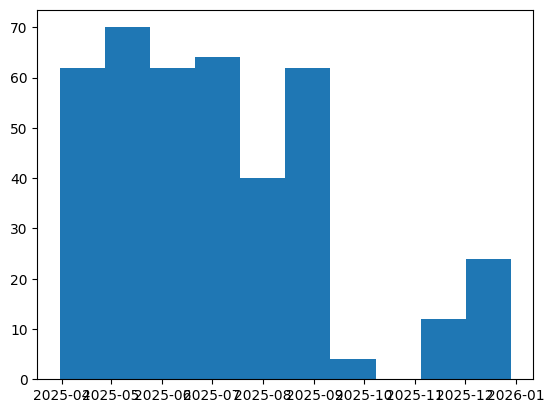

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime

plt.hist(df[df['date'] < pd.to_datetime('2026-01-01', format = '%Y-%m-%d')]['date'])

In [204]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df)

,date,match,tournament,player,oponent,player_wins,oponent_wins,best_of,tournament_tier,series_wins_1,series_losses_1,game_wins_1,game_losses_1,series_winrate_1,game_winrate_1,series_wins_2,series_losses_2,game_wins_2,game_losses_2,series_winrate_2,game_winrate_2,series_wins_3,series_losses_3,game_wins_3,game_losses_3,series_winrate_3,game_winrate_3,series_wins_4,series_losses_4,game_wins_4,game_losses_4,series_winrate_4,game_winrate_4,series_wins_5,series_losses_5,game_wins_5,game_losses_5,series_winrate_5,game_winrate_5,series_wins_6,series_losses_6,game_wins_6,game_losses_6,series_winrate_6,game_winrate_6,series_wins_8,series_losses_8,game_wins_8,game_losses_8,series_winrate_8,game_winrate_8,series_wins_10,series_losses_10,game_wins_10,game_losses_10,series_winrate_10,game_winrate_10,series_wins_12,series_losses_12,game_wins_12,game_losses_12,series_winrate_12,game_winrate_12,series_wins_16,series_losses_16,game_wins_16,game_losses_16,series_winrate_16,game_winrate_16,series_wins_18,series_losses_18,game_wins_18,game_losses_18,series_winrate_18,game_winrate_18,series_wins_24,series_losses_24,game_wins_24,game_losses_24,series_winrate_24,game_winrate_24,series_wins_28,series_losses_28,game_wins_28,game_losses_28,series_winrate_28,game_winrate_28,series_wins_32,series_losses_32,game_wins_32,game_losses_32,series_winrate_32,game_winrate_32,series_wins_36,series_losses_36,game_wins_36,game_losses_36,series_winrate_36,game_winrate_36
0,2025-05-29,Qual. (S),EWC 2025 Europe Quali - Bracket,Bly,YoungYakov,0,3,5,S,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,0.0,2.0,1.0,1.0,0.6667,1.0,0.0,2.0,1.0,1.0,0.6667,1.0,0.0,2.0,1.0,1.0,0.6667,1.0,0.0,2.0,1.0,1.0,0.6667,1.0,0.0,2.0,1.0,1.0,0.6667,1.0,0.0,2.0,1.0,1.0,0.6667
1,2025-05-29,Qual. (S),EWC 2025 Europe Quali - Bracket,Bly,Ashbringer,2,0,3,S,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,2020-10-05,Week. (B),ESL Open Cup #39 Americas,Ashbringer,Bly,0,1,3,B,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
945,2020-10-05,Week. (B),ESL Open Cup #39 Europe,Mixu,Bly,0,2,3,B,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 99 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               946 non-null    datetime64[ns]
 1   match              946 non-null    object        
 2   tournament         946 non-null    object        
 3   player             946 non-null    object        
 4   oponent            946 non-null    object        
 5   player_wins        946 non-null    int64         
 6   oponent_wins       946 non-null    int64         
 7   best_of            946 non-null    int64         
 8   tournament_tier    946 non-null    object        
 9   series_wins_1      0 non-null      object        
 10  series_losses_1    0 non-null      object        
 11  game_wins_1        0 non-null      object        
 12  game_losses_1      0 non-null      object        
 13  series_winrate_1   0 non-null      object        
 14  game_winra

In [ ]:
def get_player_race(player_url):
    resp = requests.get(player_url, headers=HEADERS)
    soup = BeautifulSoup(resp.text, "html.parser")

    for div in soup.select("div.infobox-cell-2.infobox-description"):
        if div.get_text(strip=True).lower().startswith("race"):
            value_div = div.find_next_sibling("div")
            if value_div:
                return value_div.get_text(strip=True)
            # end if
        # end if
    # end for

    return None
# end def


PLAYER_MAIN_URL = f"{BASE_URL}/{GAME}/{PLAYER_NAME}".replace('Elazer', 'ByuN')
player_race = get_player_race(PLAYER_MAIN_URL)
print(player_race)

Terran


In [134]:
df['match'].value_counts()

match
B-Tier        107
S-Tier         92
A-Tier         91
Qual. (S)      76
Qual. (B)      44
Week. (B)      37
Mon. (B)       21
Qual. (A)      21
Showm. (B)      9
C-Tier          7
Biw. (C)        7
Biw. (B)        5
Showm. (C)      2
Name: count, dtype: int64

In [125]:
df['oponent_wins'].value_counts().index

Index(['0', '2', '1', '3', '4', 'L', '5', ''], dtype='object', name='oponent_wins')

In [99]:
def get_player_race(player_url):
    resp = requests.get(player_url, headers=HEADERS)
    soup = BeautifulSoup(resp.text, "html.parser")

    for div in soup.select("div.infobox-cell-2.infobox-description"):
        if div.get_text(strip=True).lower().startswith("race"):
            value_div = div.find_next_sibling("div")
            if value_div:
                return value_div.get_text(strip=True)
            # end if
        # end if
    # end for

    return None
# end def


PLAYER_MAIN_URL = f"{BASE_URL}/{GAME}/{PLAYER_NAME}".replace('Elazer', 'ByuN')
player_race = get_player_race(PLAYER_MAIN_URL)
print(player_race)

Terran
